In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
import imageio
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D 
from mpl_toolkits import mplot3d
import plotly.graph_objs as go
import plotly.express as px

In [2]:
N=100
rho=0.5
Lo=(N/rho)**(1/3)
u=0.1
r=1.0
#r_rep=0
# r_att=0
# c_align=1.0
# c_rep=0.1
# c_att=0
eta=0.1
q=2
dt=1
T=100
u_length=Lo/20 
strict=False
CHM=False
VEM=True
DHM=False
SHM=False
DHMZ=False
SHMZ=False
txt_CHM="CHM, Periodic_BC, rho=0.5, r=1.0, u=0.1, eta=0.1"
txt_VEM="VEM, Preiodic_BC, rho=0.5, r=1.0, u=0.1, eta=0.1, q=2"
txt_DHM="DHM, Periodic_BC, rho=0.5, r=2.2, u=0.1, r-rep=0.5, r-att=2.2, c-rep= 0.1, c-att=0.0002, eta=0.1"
txt_SHM="SHM, rho=0.5 r=1.1, u=0.1, r-rep=0.1, r-att=1.1, c-rep= 0.1, c-att=0.0002, eta=0.1, q=2"
txt_DHMZ="DHMZ, rho=0.4 r=2.2, u=0.1, r-rep=0.5, r-att=2.2, c-rep= 0.1, c-att=0.00006, eta=0.1, q=2, dt=1"
txt_SHMZ="SHMZ, rho=0.4 r=2.2, u=0.1, r-rep=0.5, r-att=2.2, c-rep= 0.1, c-att=0.00006, eta=0.1, q=2, dt=1"
print(Lo)

5.848035476425731


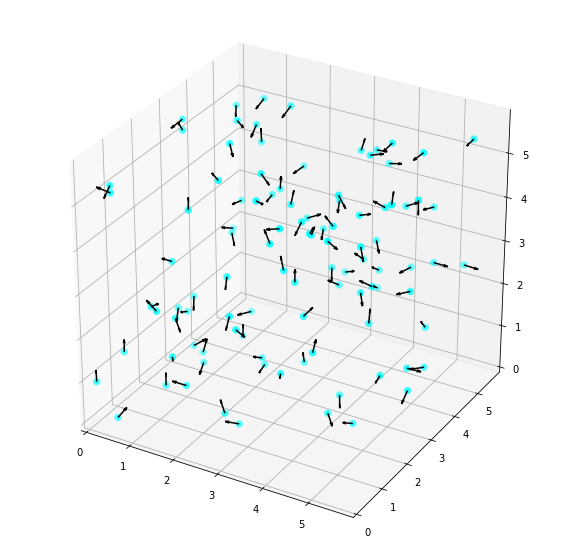

In [3]:
#defining particles positions and velocity vectors
x=np.random.uniform(low=0, high=Lo, size=N)
y=np.random.uniform(low=0, high=Lo, size=N)
z=np.random.uniform(low=0, high=Lo, size=N)

theta=np.random.uniform(low=0, high=np.pi, size=N)
phi=np.random.uniform(low=0, high=2*(np.pi), size=N)

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z,linewidths=3, color='cyan')

u_x=np.sin(theta)*np.cos(phi)
u_y=np.sin(theta)*np.sin(phi)
u_z=np.cos(theta)

  
ax.quiver(x, y, z,u_x, u_y,u_z, length=u_length, color='black')

plt.xlim(0,Lo)
plt.ylim(0,Lo)
ax.set_zlim3d([0,Lo])
              
# if strict==False:
#     if CHM==True: 
#         plt.savefig('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\CHM/frame_CHM0.jpg') 
#     elif VEM==True:
#         plt.savefig('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\VEM/frame_VEM0.jpg') 
#     elif SHM==True:
#         plt.savefig('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\SHM/frame_SHM0.jpg') 
#     else:
#         plt.savefig('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\DHM/frame_DHM0.jpg')
# else:
#     if SHMZ==True:
#          plt.savefig('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\SHMZ/frame_SHMZ0.jpg')
#     else:
#          plt.savefig('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\DHMZ/frame_DHMZ0.jpg')

plt.show()


In [4]:
def Distance(x,y,z):

    Dx = np.zeros((N,N))
    Dy = np.zeros((N,N))
    Dz = np.zeros((N,N))
    Ds = np.zeros((N,N))

    for i in range(N):
        for j in range(N): 
            Dx[i,j] = x[i] - x[j]
            Dy[i,j] = y[i] - y[j]
            Dz[i,j] = z[i] - z[j]
            Ds[i,j] = np.sqrt(Dx[i,j]**2 + Dy[i,j]**2 + Dz[i,j]**2) 
    return Ds

In [5]:
def Matrices(Ds):

    A = np.zeros((N,N))
    L = np.zeros((N,N))        
    C = np.zeros((N,N))
    B = np.zeros((N,N))
      
    if CHM==True or DHM==True or DHMZ==True:
        C = np.random.lognormal(mean=0.0, sigma=1.0, size=N**2).reshape((N,N)) 
    elif VEM==True or SHM==True or SHMZ==True:
        C = np.ones((N,N))*q
       
    if VEM==True or CHM==True:   
        B = np.ones((N,N))
    elif SHM==True or SHMZ==True or DHM==True or DHMZ==True:
        B = np.tril(np.ones(int(N)))
        
    if strict==True:
            for i in range(N):
                B[i,i]=0 
               
    for i in range(N):
        for j in range(N):
            if Ds[i,j] <= r:
                A[i,j] = 1 
            L[i,j] = C[i,j]*B[i,j]*A[i,j] 
    return L       

In [6]:
def Average_u(theta,phi,L):
    
    xx = np.sin(theta)*np.cos(phi)
    yy = np.sin(theta)*np.sin(phi)
    
    Sumy_phi=np.matmul(L,yy)
    Sumx_phi=np.matmul(L,xx)
    Sumz=np.matmul(L,np.cos(theta))
    Sumz_dom = np.sqrt(Sumx_phi**2+ Sumy_phi**2 + Sumz**2)

    Sum_theta=Sumz/Sumz_dom
    theta_av = np.arccos(Sum_theta)
    phi_av = np.arctan2(Sumy_phi,Sumx_phi)
    
    for i in range(N):
        if phi_av[i]<0:
            phi_av[i]=phi_av[i]+2*np.pi
            
    ux_av=u*np.sin(theta_av)*np.cos(phi_av)
    uy_av=u*np.sin(theta_av)*np.sin(phi_av)
    uz_av=u*np.cos(theta_av)
            
    return ux_av, uy_av, uz_av     

In [7]:
def Align_u(ux_av, uy_av, uz_av):
    
    rand_theta=np.random.uniform(low=0, high=np.pi, size=N)
    rand_phi=np.random.uniform(low=0, high=2*(np.pi), size=N)
  
  
    rand_vec_x=np.sin(rand_theta)*np.cos(rand_phi)
    rand_vec_y=np.sin(rand_theta)*np.sin(rand_phi)
    rand_vec_z=np.cos(rand_theta)
    
    
    noise_x=uy_av*rand_vec_z - uz_av*rand_vec_y
    noise_y=uz_av*rand_vec_x - ux_av*rand_vec_z
    noise_z=ux_av*rand_vec_y - uy_av*rand_vec_x
    
    norm_noise=np.sqrt(noise_x**2 + noise_y**2 + noise_z**2)
    
    rand_eta=np.random.uniform(low=0,high=eta,size=N)
    r_noise=u*np.tan(rand_eta)
    
   
    Ux=u*ux_av + r_noise*noise_x/norm_noise
    Uy=u*uy_av + r_noise*noise_y/norm_noise
    Uz=u*uz_av + r_noise*noise_z/norm_noise
    
    norm_U = np.sqrt(Ux**2+Uy**2+Uz**2)
    
    ux_align=u*Ux/norm_U
    uy_align=u*Uy/norm_U
    uz_align=u*Uz/norm_U
    
    return ux_align, uy_align, uz_align

In [8]:
def Simulation_plot(k,x,y,z,ux_align,uy_align,uz_align):

    for i in range(N):
        if x[i]>=Lo: 
            x[i]=0
        if y[i]>=Lo:
            y[i]=0
        if z[i]>=Lo:
            z[i]=0   
        if x[i]<0: 
            x[i]=Lo
        if y[i]<0:
            y[i]=Lo 
        if z[i]<0: 
            z[i]=Lo

        
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x,y,z,linewidths=3, color='cyan')
    ax.scatter(x[N-1],y[N-1],z[N-1],linewidths=4, color='black')
    ax.scatter(x[1],y[1],z[1],linewidths=4, color='black')
    
    ax.quiver(x, y, z,ux_align, uy_align, uz_align, length=u_length, color='black')
     
    fig.text(.5, .1, txt_VEM, ha='center')
    
    plt.xlim(0,Lo)
    plt.ylim(0,Lo)
    ax.set_zlim3d(0,Lo)
   
    
#     if strict==False:
#         if CHM==True:
#             plt.savefig('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\CHM/frame_CHM'+str(k+1)+'.jpg')
#         elif VEM==True:
#             plt.savefig('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\VEM/frame_VEM'+str(k+1)+'.jpg')
#         elif SHM==True:
#             plt.savefig('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\SHM/frame_SHM'+str(k+1)+'.jpg')
#         else:
#             plt.savefig('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\DHM/frame_DHM'+str(k+1)+'.jpg')
#     else:
#         if SHMZ==True:
#             plt.savefig('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\SHMZ/frame_SHMZ'+str(k+1)+'.jpg')
#         elif DHMZ==True:
#             plt.savefig('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\DHMZ/frame_DHMZ'+str(k+1)+'.jpg')
    
     
    plt.close()


    if strict==False:
        if CHM==True:    
            with imageio.get_writer('CHM_3D_PBC.gif', mode='I') as writer:
                for k in range(T+1):
                    image = imageio.imread('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\CHM/frame_CHM'+str(k)+'.jpg')
                    writer.append_data(image)

        elif VEM==True:
            with imageio.get_writer('VEM_3D_PBC.gif', mode='I') as writer:
                for k in range(T+1):
                    image = imageio.imread('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\VEM/frame_VEM'+str(k)+'.jpg')
                    writer.append_data(image)
        elif DHM==True:
            with imageio.get_writer('DHM_3D_PBC.gif', mode='I') as writer:
                for k in range(T+1):
                    image = imageio.imread('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\DHM/frame_DHM'+str(k)+'.jpg')
                    writer.append_data(image)
        else:
            with imageio.get_writer('SHM_3D_PBC.gif', mode='I') as writer:
                for k in range(T+1):
                    image = imageio.imread('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\SHM/frame_SHM'+str(k)+'.jpg')
                    writer.append_data(image)
    else:
        if DHMZ==True:
            with imageio.get_writer('DHMZ_3D_PBC.gif', mode='I') as writer:
                for k in range(T+1):
                    image = imageio.imread('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\DHMZ/frame_DHMZ'+str(k)+'.jpg')
                    writer.append_data(image)
        elif SHMZ==True:
            with imageio.get_writer('SHMZ_3D_PBC.gif', mode='I') as writer:
                for k in range(T+1):
                    image = imageio.imread('D:\Fatemeh\Complex_system\Active_matter\Collaboration\PBC_3D\SHMZ/frame_SHMZ'+str(k)+'jpg')
                    writer.append_data(image)

In [ ]:
for k in range(T):
          
    # Calculation of the distance between pair of particles
    Ds = Distance(x,y,z)

    # Calculation of Matrices
    L = Matrices(Ds)
            
    #Calculation of average velocity
    ux_av, uy_av, uz_av = Average_u(theta,phi,L)
    
   #Calculation of align velocity    
    ux_align, uy_align, uz_align = Align_u(ux_av, uy_av, uz_av)
    
    #Update particles positions
    x = x + ux_align*dt
    y = y + uy_align*dt
    z = z + uz_align*dt
    
    #Update particles angles
    theta = np.arccos(uz_align)
    phi = np.arctan2(uy_align,ux_align)
    
    Simulation_plot(k,x,y,z,ux_align,uy_align,uz_align)
    
   